<a href="https://colab.research.google.com/github/rbbh/Forecasting-Time-Series-with-Algorithm-Ensembling/blob/master/SVR_%2B_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import svm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
from google.colab import files
uploaded = files.upload()

Saving airlines2.txt to airlines2.txt


In [0]:
import io
import pandas as pd

# Un-comment the line for the data base that
# you want to predict

data = pd.read_csv(io.BytesIO(uploaded['airlines2.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['DadosONS.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['carsales.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['coloradoRiver.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['accidentalDeathUSA.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['electric.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['gas.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['lakeerie.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['milk.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['redwine.txt']))

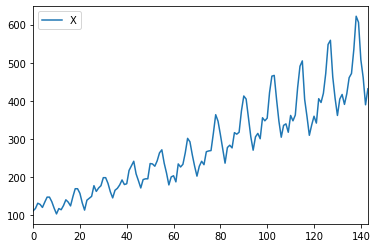

In [4]:
data.plot()


In [5]:
len(data)

144

In [0]:
#Normalizing the data
data_n = data.copy()
data_n = data/data.max()

In [7]:
# TODO: Create function for the Lag used for the prediction
# We will use 12 for the lag dimension if the series repeats 
# itself annually, 3 if it is trimestrial etc.

# Note: For the "ONS" data base, make "dimensions" = 3
# NOTE: For the "Milk" data base, make "dimensions" = 24

dimensions = 12
data_cn = pd.concat([data_n.shift(i) for i in range(0 + dimensions + 1)], axis = 1)

print(data_cn)

            X         X         X  ...         X         X         X
0    0.180064       NaN       NaN  ...       NaN       NaN       NaN
1    0.189711  0.180064       NaN  ...       NaN       NaN       NaN
2    0.212219  0.189711  0.180064  ...       NaN       NaN       NaN
3    0.207395  0.212219  0.189711  ...       NaN       NaN       NaN
4    0.194534  0.207395  0.212219  ...       NaN       NaN       NaN
..        ...       ...       ...  ...       ...       ...       ...
139  0.974277  1.000000  0.860129  ...  0.654341  0.744373  0.898714
140  0.816720  0.974277  1.000000  ...  0.581994  0.654341  0.744373
141  0.741158  0.816720  0.974277  ...  0.651125  0.581994  0.654341
142  0.627010  0.741158  0.816720  ...  0.670418  0.651125  0.581994
143  0.694534  0.627010  0.741158  ...  0.628617  0.670418  0.651125

[144 rows x 13 columns]


In [8]:
# Splitting the data into train, validation and test

from sklearn.model_selection import train_test_split

X = data_cn.iloc[12:,1:]

y = data_cn.iloc[12:,0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, shuffle = False)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)


print(len(y_val))
print(len(y_test))
print(len(y_train))


26
27
79


In [0]:
def pso(n_particles, iterations, dimensions, inertia):

    # Range of SVR's hyperparameters (Particles' search space)
    # C, Epsilon and Gamma
    max_c = 1e4
    min_c = 1e-3
    max_e = 1e-1
    min_e = 1e-8
    max_g = 1e3
    min_g = 1e-3
    
    # Initializing particles' positions randomly, inside
    # the search space
    x = np.random.rand(n_particles, 1)*(max_c - min_c) + min_c
    y = np.random.rand(n_particles, 1)*(max_e - min_e) + min_e
    z = np.random.rand(n_particles, 1)*(max_g - min_g) + min_g

    c = np.concatenate((x,y,z), axis=1)

    # Initializing particles' parameters
    v = np.zeros((n_particles, dimensions))
    c1 = 2
    c2 = 2
    p_best = np.zeros((n_particles, dimensions))
    p_best_val = np.zeros(n_particles) + sys.maxsize  
    g_best = np.zeros(dimensions)
    g_best_val = sys.maxsize

    best_iter = np.zeros(iterations)

    # Initializing regression variables
    p_best_RGS = np.empty((n_particles), dtype = object);
    g_best_RGS = sys.maxsize

    

    # Displaying tridimensional search space
    plot(c)

    from sklearn.metrics import mean_squared_error
    
    for i in range(iterations):

        for j in range(n_particles):
          # Starting Regression
          rgs = svm.SVR(C = c[j][0], epsilon = c[j][1], gamma = c[j][2])

          # Fitting the curve
          rgs.fit(X_train, y_train)
          y_predict = rgs.predict(X_val)

          # To un-normalize the data:
          # Multiply the values by
          # data.to_numpy().max()

          # Using Mean Squared Error to verify prediction accuracy
          mse = mean_squared_error(y_val, y_predict) 

          # If mse value for that search point, for that particle,
          # is less than its personal best point,
          # replace personal best
          if(mse < p_best_val[j]):   # mse < p_best_val[j]
              # The value below represents the current least Mean Squared Error
              p_best_val[j] = mse
              
              p_best_RGS[j] = rgs
                           

              # The value below represents the current search coordinates for
              # the particle's current least Mean Squared Error found
              p_best[j] = c[j].copy()
              
          # Using auxiliar variable to get the index of the
          # particle that found the configuration with the 
          # minimum MSE value
          aux = np.argmin(p_best_val)        
        
          if(p_best_val[aux] < g_best_val):
              # Assigning Particle's current best MSE to the Group's best    
              g_best_val = p_best_val[aux]

              # Assigning Particle's current best configuration to the Group's best
              g_best = p_best[aux].copy()

              # Group best regressor:
              # the combination of C, Epsilon and Gamma
              # that computes the best fitting curve
              g_best_RGS = p_best_RGS[aux]

        
          rand1 = np.random.random()
          rand2 = np.random.random()

          # The variable below influences directly the particle's velocity.
          # It can either make it smaller or bigger. 
          w = inertia

          # The equation below represents Particle's velocity, which is
          # the rate of change in its position
          v[j] = w*v[j] + c1*(p_best[j] - c[j])*rand1 + c2*(g_best - c[j])*rand2

          # Change in the Particle's position 
          c[j] = c[j] + v[j]

          # Below is a series of conditions that stop the particles from
          # leaving the search space
          if(c[j][2] < min_g):
            c[j][2] = min_g
          if(c[j][2] > max_g):
            c[j][2] = max_g
          if(c[j][1] < min_e):
            c[j][1] = min_e
          if(c[j][1] > max_e):
            c[j][1] = max_e
          if(c[j][0] < min_c):
            c[j][0] = min_c
          if(c[j][0] > max_c):
            c[j][0] = max_c
            
     
        # The variable below represents the least Mean Squared Error
        # of the current iteration
        best_iter[i] = g_best_val
                
        print('Best value iteration # %d = %f\n'%(i, g_best_val))

    # Coordinates found after all the iterations
    print('Group Best configuration found: ')
    print(g_best)
    print('\n')
    print('Best Regressor:\n')
    print(g_best_RGS)
    print('\n')
    # Displaying the MSE value variation throughout the iterations
    t = range(iterations)
    plt.plot(t, best_iter, label='Fitness Value')
    plt.legend()
    plt.show()

    # Displaying Particles' final configuration
    plot(c)

    # Making the prediction with the best configuration of C, Epsilon and
    # Gamma found by the particles
    predict_test = g_best_RGS.predict(X_test)

    
    # Displaying actual values and predicted values for
    # Group's best configuration found overall
    print(color.BOLD + 'Predictions with the Population Best Value found:\n' + color.END)
    evaluate(predict_test)  
      


In [0]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'



In [0]:
# Function that displays tridimensional plot
def plot(some_list):
 
  ax = Axes3D(plt.figure())
  ax.scatter3D(some_list[:,0], some_list[:,1], some_list[:,2], color = 'r')
  ax.set_xlabel('$C$', fontsize = 20)
  ax.set_ylabel('$\epsilon$', fontsize = 25)
  ax.zaxis.set_rotate_label(False) 
  ax.set_zlabel('$\gamma$', fontsize=30, rotation = 0)
  ax.zaxis._axinfo['label']['space_factor'] = 1.0
  plt.show()

  print('\n')
  print('\n')

In [0]:
def evaluate(predictions):

    from sklearn.metrics import mean_squared_error
    import statistics as st

    predict_test = predictions

    # To un-normalize the data:
    # Multiply the values by
    # data.to_numpy().max()

    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted')
    plt.legend()
    plt.show()
    
    mse = mean_squared_error(y_test, predict_test)
    print('\n')
    print('\n')
    print('Mean Squared Error for the Test Set:\t %f' %mse)
    print('\n')
    print('\n')
    print('Predictions Average:\t %f' %((predict_test.sum()/len(predict_test))))
    print('\n')
    print('\n')
    print('Predictions Median:\t %f' %(st.median(predict_test)))
    print('\n')
    print('\n')

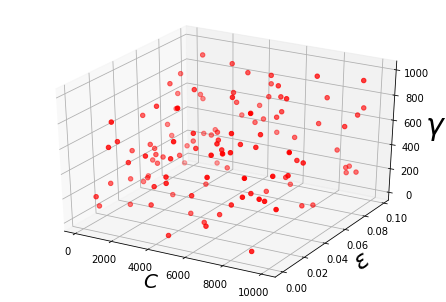





Best value iteration # 0 = 0.023822

Best value iteration # 1 = 0.001298

Best value iteration # 2 = 0.001114

Best value iteration # 3 = 0.001114

Best value iteration # 4 = 0.001114

Best value iteration # 5 = 0.001114

Best value iteration # 6 = 0.001114

Best value iteration # 7 = 0.001114

Best value iteration # 8 = 0.001114

Best value iteration # 9 = 0.001090

Best value iteration # 10 = 0.001090

Best value iteration # 11 = 0.001090

Best value iteration # 12 = 0.001090

Best value iteration # 13 = 0.001090

Best value iteration # 14 = 0.001090

Best value iteration # 15 = 0.001090

Best value iteration # 16 = 0.001090

Best value iteration # 17 = 0.001090

Best value iteration # 18 = 0.001085

Best value iteration # 19 = 0.001085

Best value iteration # 20 = 0.001085

Best value iteration # 21 = 0.001085

Best value iteration # 22 = 0.001083

Best value iteration # 23 = 0.001083

Best value iteration # 24 = 0.001083

Best value iteration # 25 = 0.001083

Best value iterati

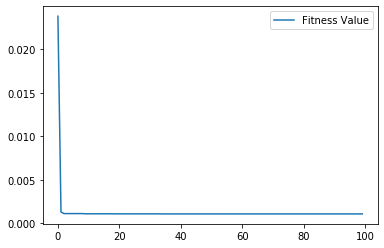

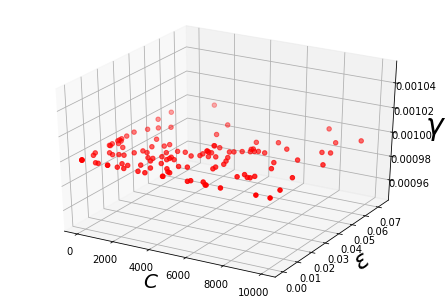





Predictions with the Population Best Value found:



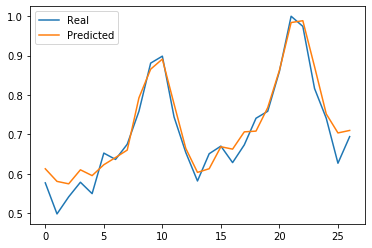





Mean Squared Error for the Test Set:	 0.001155




Predictions Average:	 0.722106




Predictions Median:	 0.703887






In [13]:
pso(120, 100, 3, 1)

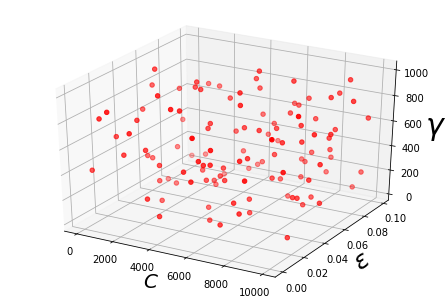





Best value iteration # 0 = 0.036500

Best value iteration # 1 = 0.001114

Best value iteration # 2 = 0.001114

Best value iteration # 3 = 0.001096

Best value iteration # 4 = 0.001096

Best value iteration # 5 = 0.001093

Best value iteration # 6 = 0.001093

Best value iteration # 7 = 0.001093

Best value iteration # 8 = 0.001082

Best value iteration # 9 = 0.001082

Best value iteration # 10 = 0.001082

Best value iteration # 11 = 0.001082

Best value iteration # 12 = 0.001082

Best value iteration # 13 = 0.001082

Best value iteration # 14 = 0.001082

Best value iteration # 15 = 0.001082

Best value iteration # 16 = 0.001082

Best value iteration # 17 = 0.001082

Best value iteration # 18 = 0.001082

Best value iteration # 19 = 0.001072

Best value iteration # 20 = 0.001069

Best value iteration # 21 = 0.001069

Best value iteration # 22 = 0.001069

Best value iteration # 23 = 0.001069

Best value iteration # 24 = 0.001069

Best value iteration # 25 = 0.001069

Best value iterati

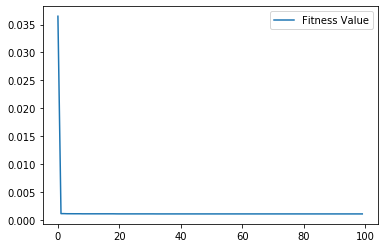

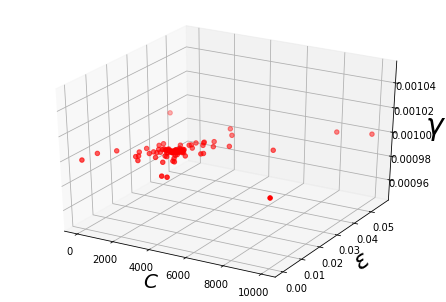





Predictions with the Population Best Value found:



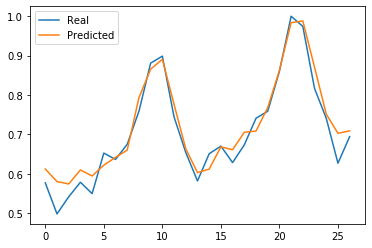





Mean Squared Error for the Test Set:	 0.001130




Predictions Average:	 0.721555




Predictions Median:	 0.702973






In [14]:
pso(120, 100, 3, 0.8)

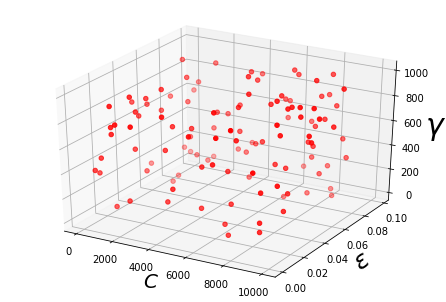





Best value iteration # 0 = 0.028638

Best value iteration # 1 = 0.001448

Best value iteration # 2 = 0.001190

Best value iteration # 3 = 0.001139

Best value iteration # 4 = 0.001139

Best value iteration # 5 = 0.001101

Best value iteration # 6 = 0.001101

Best value iteration # 7 = 0.001101

Best value iteration # 8 = 0.001093

Best value iteration # 9 = 0.001093

Best value iteration # 10 = 0.001093

Best value iteration # 11 = 0.001082

Best value iteration # 12 = 0.001082

Best value iteration # 13 = 0.001082

Best value iteration # 14 = 0.001082

Best value iteration # 15 = 0.001082

Best value iteration # 16 = 0.001074

Best value iteration # 17 = 0.001074

Best value iteration # 18 = 0.001074

Best value iteration # 19 = 0.001074

Best value iteration # 20 = 0.001074

Best value iteration # 21 = 0.001073

Best value iteration # 22 = 0.001073

Best value iteration # 23 = 0.001073

Best value iteration # 24 = 0.001073

Best value iteration # 25 = 0.001073

Best value iterati

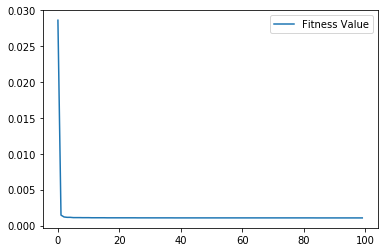

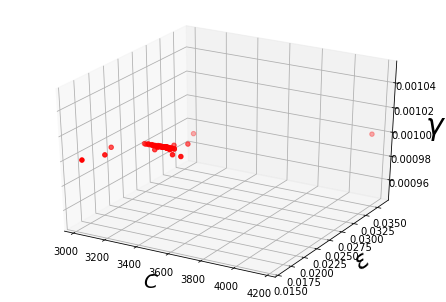





Predictions with the Population Best Value found:



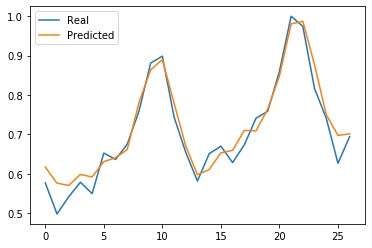





Mean Squared Error for the Test Set:	 0.001060




Predictions Average:	 0.719281




Predictions Median:	 0.697613






In [15]:
pso(120, 100, 3, 0.6)

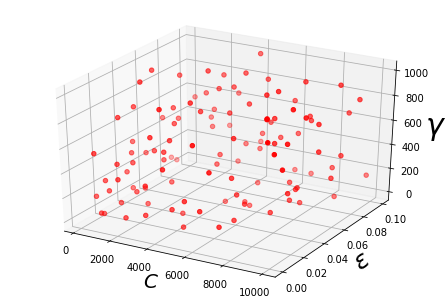





Best value iteration # 0 = 0.004470

Best value iteration # 1 = 0.001221

Best value iteration # 2 = 0.001107

Best value iteration # 3 = 0.001107

Best value iteration # 4 = 0.001107

Best value iteration # 5 = 0.001088

Best value iteration # 6 = 0.001088

Best value iteration # 7 = 0.001087

Best value iteration # 8 = 0.001076

Best value iteration # 9 = 0.001076

Best value iteration # 10 = 0.001074

Best value iteration # 11 = 0.001071

Best value iteration # 12 = 0.001070

Best value iteration # 13 = 0.001069

Best value iteration # 14 = 0.001069

Best value iteration # 15 = 0.001066

Best value iteration # 16 = 0.001066

Best value iteration # 17 = 0.001065

Best value iteration # 18 = 0.001065

Best value iteration # 19 = 0.001065

Best value iteration # 20 = 0.001062

Best value iteration # 21 = 0.001062

Best value iteration # 22 = 0.001062

Best value iteration # 23 = 0.001062

Best value iteration # 24 = 0.001062

Best value iteration # 25 = 0.001062

Best value iterati

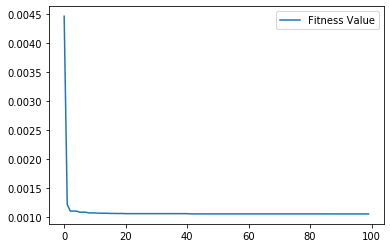

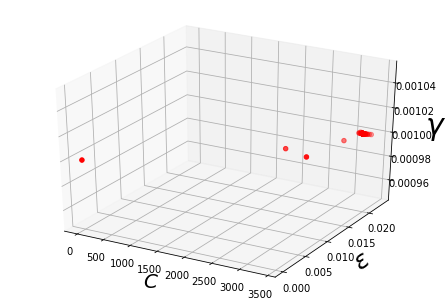





Predictions with the Population Best Value found:



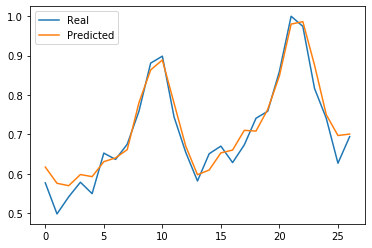





Mean Squared Error for the Test Set:	 0.001061




Predictions Average:	 0.719044




Predictions Median:	 0.697278






In [16]:
pso(120, 100, 3, 0.2)